In [1]:
# === 0. Install/imports (run once in Colab) ===
# imbalanced-learn is usually available in Colab. If not, uncomment the install line:
# !pip install -U imbalanced-learn

import warnings
warnings.filterwarnings("ignore")

# Drive + data
from google.colab import drive
drive.mount('/content/drive')

# Standard libs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn / imblearn
import sklearn
print("sklearn version:", sklearn.__version__)  # should be 1.6.1 in your Colab env

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# For saving
import joblib


Mounted at /content/drive
sklearn version: 1.6.1


In [2]:
# === 1. Load dataset ===
DATA_PATH = "/content/drive/MyDrive/BankMarketingProject/data/raw/bank.csv"  # change if needed
df = pd.read_csv(DATA_PATH, sep=';')
print("Shape:", df.shape)
df.head()


Shape: (4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# === 2. Quick checks ===
print(df.info())
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None

Target distribution:
y
no     0.88476
yes    0.11524
Name: proportion, dtype: float64


In [4]:
# === 3. Basic feature engineering & target encoding ===
# (Adjust these if you want to follow your project's original choices.)
USE_DURATION = True   # set False to drop 'duration' to avoid leakage

# 3.1 encode target
df['y'] = df['y'].map({'yes':1, 'no':0})

# 3.2 pdays handling: -1 means never contacted. create flag and imputed pdays
df['contacted_before'] = (df['pdays'] != -1).astype(int)
df['pdays_imputed'] = df['pdays'].replace(-1, np.nan)
df['pdays_imputed'] = df['pdays_imputed'].fillna(df['pdays_imputed'].median())

# 3.3 balance: clip extremes and log transform to reduce skew
low_q, high_q = df['balance'].quantile([0.01, 0.99])
df['balance_clipped'] = df['balance'].clip(low_q, high_q)
df['balance_log'] = np.log1p(df['balance_clipped'] - df['balance_clipped'].min() + 1)

# 3.4 drop columns we no longer need (keep original columns if you prefer)
# We'll drop original 'pdays' (we used pdays_imputed & contacted_before)
df = df.drop(columns=['pdays', 'balance'])  # keep balance_log instead of raw balance

# optionally drop duration if you want to avoid leakage
if not USE_DURATION and 'duration' in df.columns:
    df = df.drop(columns=['duration'])

print("After engineering shape:", df.shape)
df.head()


After engineering shape: (4521, 19)


,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,contacted_before,pdays_imputed,balance_clipped,balance_log
0,30,unemployed,married,primary,no,no,no,cellular,19,oct,79,1,0,unknown,0,0,189.0,1787.0,7.808079
1,33,services,married,secondary,no,yes,yes,cellular,11,may,220,1,4,failure,0,1,339.0,4789.0,8.605644
2,35,management,single,tertiary,no,yes,no,cellular,16,apr,185,1,1,failure,0,1,330.0,1350.0,7.612535
3,30,management,married,tertiary,no,yes,yes,unknown,3,jun,199,4,0,unknown,0,0,189.0,1476.0,7.672944
4,59,blue-collar,married,secondary,no,yes,no,unknown,5,may,226,1,0,unknown,0,0,189.0,0.0,6.512340


In [5]:
# === 4. Define features (X) and target (y) ===
X = df.drop(columns=['y'])
y = df['y']

# numeric and categorical columns for ColumnTransformer
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['age', 'day', 'duration', 'campaign', 'previous', 'contacted_before', 'pdays_imputed', 'balance_clipped', 'balance_log']
Categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [6]:
# === 5. Train / Validation / Test split ===
# We do: Train 60% | Val 20% | Test 20% (by two splits)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)
# Now: train ~60%, val ~20%, test ~20%

print("Train:", X_train.shape, y_train.sum(), "/", len(y_train))
print("Val:  ", X_val.shape, y_val.sum(), "/", len(y_val))
print("Test: ", X_test.shape, y_test.sum(), "/", len(y_test))


Train: (2712, 18) 313 / 2712
Val:   (904, 18) 104 / 904
Test:  (905, 18) 104 / 905


In [7]:
# === 6. Preprocessor (ColumnTransformer) ===
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)


In [8]:
# === 7. Build pipelines for each classifier (preproc -> SMOTE -> classifier) ===
smote = SMOTE(random_state=42)

# Logistic
pipe_log = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

# SVM
pipe_svm = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', SVC(probability=True))   # we'll tune kernel/C/gamma
])

# Random Forest
pipe_rf = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42))
])


In [9]:
# === 8. Hyperparameter grids (small to moderate grids) ===
param_grid_log = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2']   # liblinear supports l1/l2; keep l2 for stability
}

param_grid_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01, 0.001],
    'clf__kernel': ['rbf', 'linear']
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}


In [10]:
# === 9. GridSearchCV on the TRAIN split (with internal CV) ===
# We'll optimize for ROC-AUC since data is imbalanced and AUC is robust.
cv = 5
scoring = 'roc_auc'
n_jobs = -1

gs_log = GridSearchCV(pipe_log, param_grid_log, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=1)
gs_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=1)
gs_rf  = GridSearchCV(pipe_rf,  param_grid_rf,  cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=1)

# Fit (this may take time)
print("Tuning Logistic Regression...")
gs_log.fit(X_train, y_train)

print("Tuning SVM...")
gs_svm.fit(X_train, y_train)

print("Tuning Random Forest...")
gs_rf.fit(X_train, y_train)


Tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tuning SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'day',
                                                                          'duration',
                                                                          'campaign',
                                                                          'previous',
                                                                          'contacted_before',
                                                                          'pdays_imputed',
                                                                          'balance_clipped',
                                                                          'balance_log']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [11]:
# === 10. Best params & CV scores ===
print("Logistic best:", gs_log.best_params_, "best CV score:", gs_log.best_score_)
print("SVM best:     ", gs_svm.best_params_, "best CV score:", gs_svm.best_score_)
print("RF best:      ", gs_rf.best_params_, "best CV score:", gs_rf.best_score_)

# get best estimators
best_log = gs_log.best_estimator_
best_svm = gs_svm.best_estimator_
best_rf  = gs_rf.best_estimator_


Logistic best: {'clf__C': 0.1, 'clf__penalty': 'l2'} best CV score: 0.8852683190234961
SVM best:      {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'} best CV score: 0.8928575279061421
RF best:       {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200} best CV score: 0.8982753205460543


In [12]:
# === 11. Evaluation helper (plots + metrics) ===
def evaluate_and_plot(model, X_eval, y_eval, title_prefix="Model"):
    # predictions & scores
    y_pred = model.predict(X_eval)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_eval)[:,1]
    else:
        # for models without prob (rare here) use decision function
        try:
            y_score = model.decision_function(X_eval)
        except:
            y_score = None

    # metrics
    acc = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred, zero_division=0)
    rec = recall_score(y_eval, y_pred, zero_division=0)
    f1 = f1_score(y_eval, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_eval, y_score) if y_score is not None else None

    print(f"\n--- {title_prefix} METRICS ---")
    print(f"Accuracy: {acc:.4f}")
    if auc_score is not None:
        print(f"ROC-AUC:  {auc_score:.4f}")
    print("Classification report:")
    print(classification_report(y_eval, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{title_prefix} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve if score available
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_eval, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title_prefix} - ROC Curve")
        plt.legend()
        plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc_score}



--- Logistic Regression (val) METRICS ---
Accuracy: 0.8385
ROC-AUC:  0.8986
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       800
           1       0.40      0.77      0.52       104

    accuracy                           0.84       904
   macro avg       0.68      0.81      0.71       904
weighted avg       0.90      0.84      0.86       904



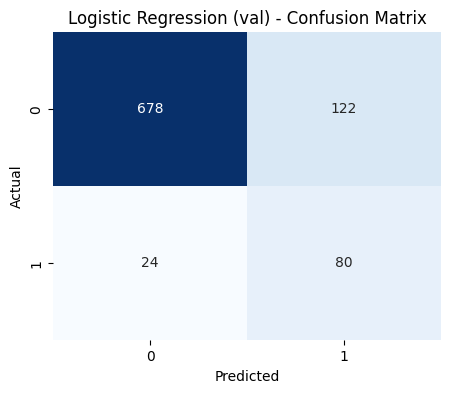

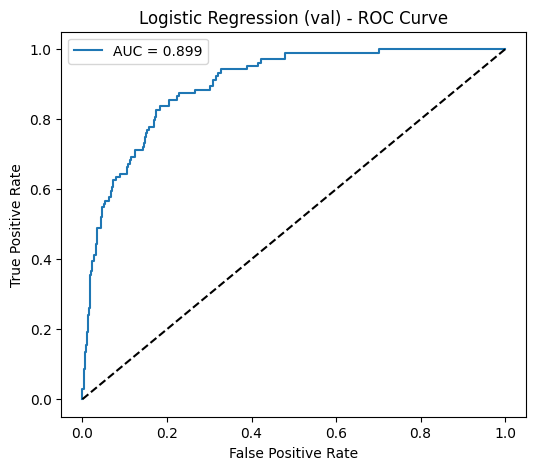


--- SVM (val) METRICS ---
Accuracy: 0.8208
ROC-AUC:  0.8933
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       800
           1       0.36      0.72      0.48       104

    accuracy                           0.82       904
   macro avg       0.66      0.78      0.69       904
weighted avg       0.89      0.82      0.84       904



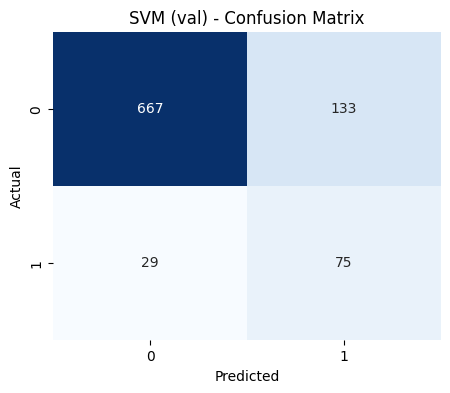

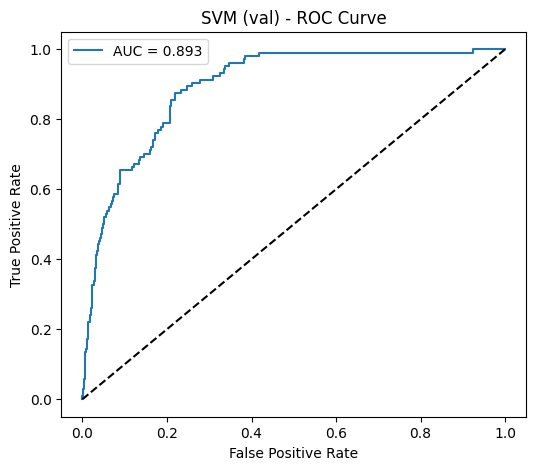


--- Random Forest (val) METRICS ---
Accuracy: 0.8960
ROC-AUC:  0.9063
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       800
           1       0.58      0.34      0.43       104

    accuracy                           0.90       904
   macro avg       0.75      0.65      0.68       904
weighted avg       0.88      0.90      0.88       904



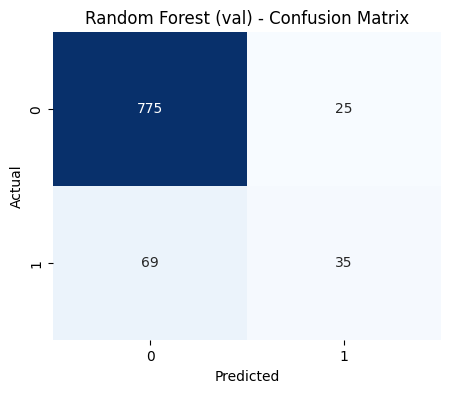

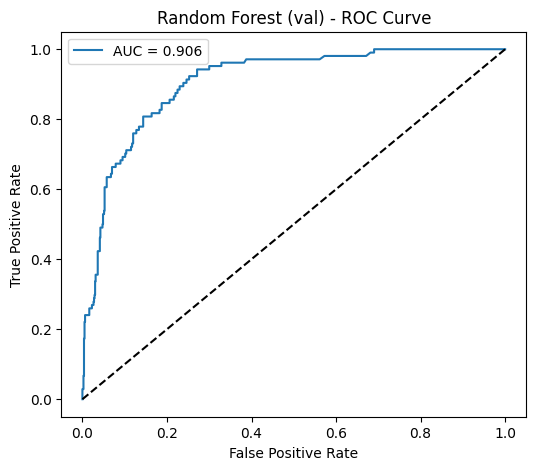

In [13]:
# === 12. Evaluate on VALIDATION set (these are your 'validation' results) ===
results_val = {}
results_val['Logistic'] = evaluate_and_plot(best_log, X_val, y_val, title_prefix="Logistic Regression (val)")
results_val['SVM']      = evaluate_and_plot(best_svm, X_val, y_val, title_prefix="SVM (val)")
results_val['RandomForest'] = evaluate_and_plot(best_rf, X_val, y_val, title_prefix="Random Forest (val)")



--- Logistic Regression (test) METRICS ---
Accuracy: 0.8254
ROC-AUC:  0.8919
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       801
           1       0.37      0.76      0.50       104

    accuracy                           0.83       905
   macro avg       0.67      0.80      0.70       905
weighted avg       0.90      0.83      0.85       905



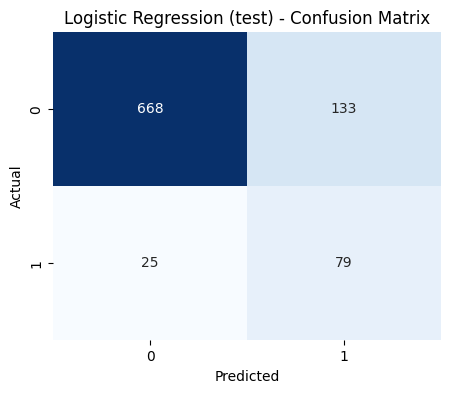

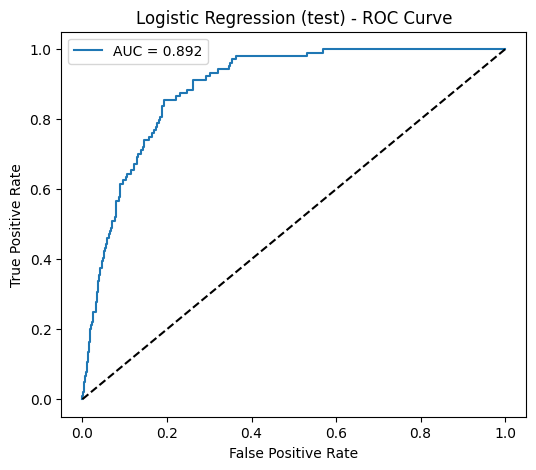


--- SVM (test) METRICS ---
Accuracy: 0.8365
ROC-AUC:  0.8991
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       801
           1       0.40      0.82      0.53       104

    accuracy                           0.84       905
   macro avg       0.68      0.83      0.72       905
weighted avg       0.91      0.84      0.86       905



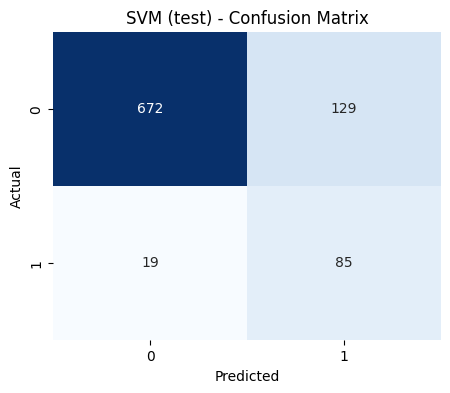

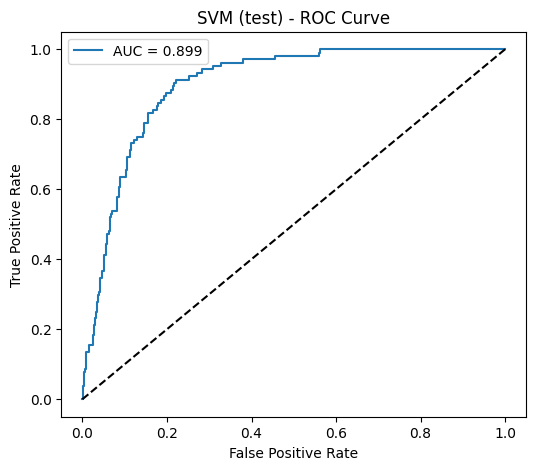


--- Random Forest (test) METRICS ---
Accuracy: 0.8928
ROC-AUC:  0.9033
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       801
           1       0.55      0.40      0.46       104

    accuracy                           0.89       905
   macro avg       0.74      0.68      0.70       905
weighted avg       0.88      0.89      0.89       905



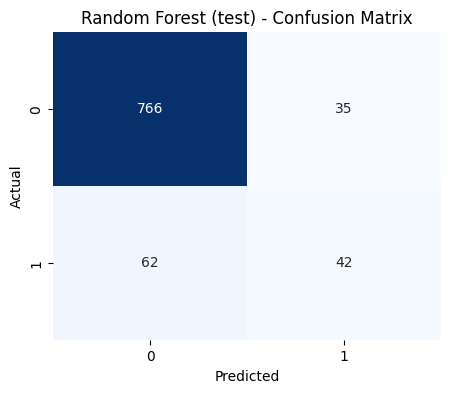

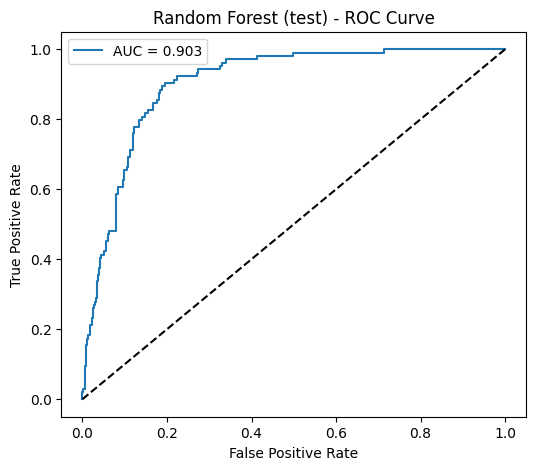

In [14]:
# === 13. If satisfied with validation, optionally retrain best models on TRAIN+VAL and evaluate on TEST ===
# We will refit the best estimator on TRAIN+VAL (GridSearchCV.best_estimator_ is already refit on TRAIN by default),
# but better: retrain using the same pipeline with best params on full train+val to get final model.

# combine train+val
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Re-build final pipelines with the best parameters and fit on train_full
# Logistic final
final_log = best_log
final_log.fit(X_train_full, y_train_full)

# SVM final
final_svm = best_svm
final_svm.fit(X_train_full, y_train_full)

# RF final
final_rf = best_rf
final_rf.fit(X_train_full, y_train_full)

# Evaluate on TEST set
results_test = {}
results_test['Logistic'] = evaluate_and_plot(final_log, X_test, y_test, title_prefix="Logistic Regression (test)")
results_test['SVM']      = evaluate_and_plot(final_svm, X_test, y_test, title_prefix="SVM (test)")
results_test['RandomForest'] = evaluate_and_plot(final_rf, X_test, y_test, title_prefix="Random Forest (test)")


Validation metrics:


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Logistic,0.838,0.396,0.769,0.523,0.899
SVM,0.821,0.361,0.721,0.481,0.893
RandomForest,0.896,0.583,0.337,0.427,0.906



Test metrics:


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Logistic,0.825,0.373,0.760,0.500,0.892
SVM,0.836,0.397,0.817,0.535,0.899
RandomForest,0.893,0.545,0.404,0.464,0.903


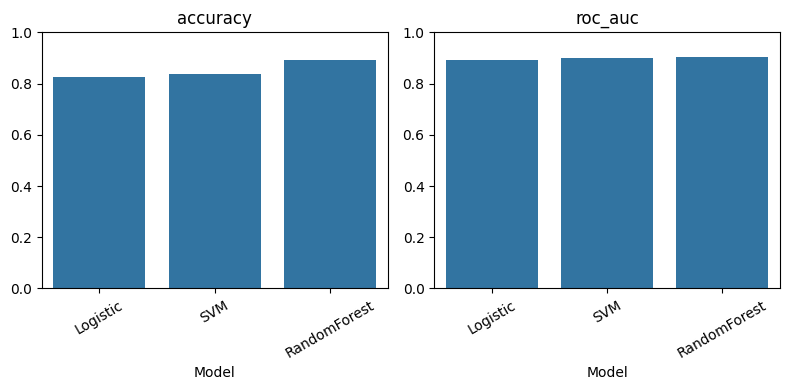

In [15]:
# === 14. Summary table for validation & test metrics ===
df_val = pd.DataFrame(results_val).T
df_val.index.name = 'Model'
df_test = pd.DataFrame(results_test).T
df_test.index.name = 'Model'

print("Validation metrics:")
display(df_val.style.background_gradient(cmap='Blues').format("{:.3f}"))
print("\nTest metrics:")
display(df_test.style.background_gradient(cmap='Greens').format("{:.3f}"))

# Basic barplot comparison (Accuracy & ROC-AUC on test)
plt.figure(figsize=(8,4))
metrics_to_plot = ['accuracy', 'roc_auc']
for i, m in enumerate(metrics_to_plot):
    plt.subplot(1, len(metrics_to_plot), i+1)
    sns.barplot(x=df_test.index, y=df_test[m].values)
    plt.title(m)
    plt.ylim(0,1)
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [17]:
# === 15. Save the best final model & preprocessor if you want ===
joblib.dump(final_rf, "/content/drive/MyDrive/BankMarketingProject/models/best_rf_pipeline.joblib")
joblib.dump(final_svm, "/content/drive/MyDrive/BankMarketingProject/models/best_svm_pipeline.joblib")
joblib.dump(final_log, "/content/drive/MyDrive/BankMarketingProject/models/best_log_pipeline.joblib")
print("Saved pipelines to /content/drive/MyDrive/BankMarketingProject/models/")


Saved pipelines to /content/drive/MyDrive/BankMarketingProject/models/


In [18]:
print(sklearn.__version__)

1.6.1
